In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Installation
If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.

In [ ]:
%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git
%cd Pearl
%pip install .
%cd ..

Cloning into 'Pearl'...
remote: Enumerating objects: 5265, done.
remote: Counting objects: 100% (1477/1477), done.
remote: Compressing objects: 100% (401/401), done.
remote: Total 5265 (delta 1166), reused 1272 (delta 1065), pack-reused 3788
Receiving objects: 100% (5265/5265), 53.40 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (3496/3496), done.
/content/Pearl
Processing /content/Pearl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 32.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing m

## Import Modules

In [ ]:
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.action_representation_modules.one_hot_action_representation_module import OneHotActionTensorRepresentationModule
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent

from pearl.user_envs.wrappers.gym_avg_torque_cost import GymAvgTorqueWrapper
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
import gymnasium as gym
from pearl.policy_learners.sequential_decision_making.td3 import TD3
from pearl.neural_networks.sequential_decision_making.actor_networks import VanillaContinuousActorNetwork
from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import (
    FIFOOffPolicyReplayBuffer,
)
from pearl.policy_learners.exploration_modules.common.normal_distribution_exploration import (
    NormalDistributionExploration,
)
from pearl.safety_modules.reward_constrained_safety_module import (
    RCSafetyModuleCostCriticContinuousAction,
)
from matplotlib import pyplot as plt


import torch
import matplotlib.pyplot as plt
import numpy as np
import os

set_seed(0)



```
# This is formatted as code
```

## Actor-critic algorithms with safety constraints

The class of actor-critic algorithms is known for its practical success. The Pearl library includes several popular algorithms in this class, such as PPO, DDPG, SAC, and TD3.

In this tutorial, we will demonstrate how to use the TD3 algorithm with Pearl. Implementing other algorithms is just as simple; you only need to modify the Policy Learner to the appropriate algorithm.

Pearl also supports safe training, which allows an algorithm designer to optimize a reward function while adhering to additional constraints. We will show you how to use safe training by instantiating the Safety Module with the Reward Constraint Safety Module.

Let's dive into the code. First, we will create a Mujoco environment with an additional torque cost function. This environment is designed as a wrapper on top of Gym, so at each step, the environment returns the usual reward and an additional cost function. The cost function we use is $c(s,a)= ||a ||^2$, which represents the squared norm of the action. This cost function represents the average power of the action, and often, algorithm designers wish to restrict this quantity. In later sections, we will use the additional cost function to place additional constraints on the agent.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a HalfCheetah with an additional torque cost by using the GymAvgTorqueWrapper wrapper
env = GymEnvironment(GymAvgTorqueWrapper(gym.make("HalfCheetah-v4")))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## TD3 algorithms in Pearl

With the environment ready, we now test the performance of the TD3 algorithm. We set the Policy Learner to be TD3 and configure the replay buffer, but do not add any special safety module at this point.

The following code demonstrates the performance of TD3 in the environment with the additional torque cost. As the learning progresses, we track and print both the cumulative reward and the cumulative cost.

In [ ]:

# setup TD3 algorithm
td3_agent = PearlAgent(
                    policy_learner=TD3(
                        state_dim=env.observation_space.shape[0],
                        action_space=env.action_space,
                        actor_hidden_dims= [256, 256],
                        critic_hidden_dims= [256, 256],
                        training_rounds= 1,
                        batch_size= 256,
                        actor_network_type= VanillaContinuousActorNetwork,
                        critic_network_type= VanillaQValueNetwork,
                        actor_soft_update_tau= 0.005,
                        critic_soft_update_tau= 0.005,
                        actor_learning_rate= 1e-3,
                        critic_learning_rate= 3e-4,
                        discount_factor= 0.99,
                        actor_update_freq= 2,
                        actor_update_noise= 0.2,
                        actor_update_noise_clip= 0.5,
                        exploration_module=NormalDistributionExploration(
                            mean=0.0,
                            std_dev=0.1,
                            ),
                    ),
                    replay_buffer=FIFOOffPolicyReplayBuffer(
                        capacity=100000,
                        has_cost_available=True
                    ),
                    safety_module=None,
                )

# Run TD3 on the environment
number_of_steps = 200000
print_every_x_steps = 20000
record_period = 1000

td3_info = online_learning(
    td3_agent,
    env,
    number_of_steps=number_of_steps,
    print_every_x_steps=print_every_x_steps,
    record_period=record_period,
)

episode 20, step 20000, agent=PearlAgent with TD3, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 49.970514269312844
return_cost: 806.2538956999779
episode 40, step 40000, agent=PearlAgent with TD3, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: -14.736769429975539
return_cost: 787.3026733063161
episode 60, step 60000, agent=PearlAgent with TD3, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 1430.6730238944292
return_cost: 813.093893378973
episode 80, step 80000, agent=PearlAgent with TD3, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 2032.4104736470617
return_cost: 794.4528419971466
episode 100, step 100000, agent=PearlAgent with TD3, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 2657.43493815884
return_cost: 793.5689518451691
episode 120, step 120000, agent=PearlAgent with TD3, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 2887.5689703784883
return_cost: 798.2803127765656
episode 140, step 140000, agent=PearlAgent with TD3, FIFOOffPolicyRe

## TD3 with Reward Constrained safety module in Pearl

The modular design of Pearl enables us to easily combine the TD3 algorithm with a safety module. One such generic safety module we developed is based on the Reward Constrained (RC) Policy Optimization (PO) framework [1].

This approach is versatile and can be applied to any actor-critic algorithm. To try its Pearl implementation yourself, simply instantiate the Pearl agent safety module with the RC safety module.

To integrate TD3 with the RC safety module, simply instantiate PearlAgent with TD3 as before, and set the safety_module parameter to RCSafetyModuleCostCriticContinuousAction. The following code demonstrates this.

[1] Reward Constrained Policy Optimization, C. Tessler, D. Mankowitz, S. Mannor, 2019, https://arxiv.org/abs/1805.11074.


In [ ]:
# setup RCTD3 algorithm, TD3 with reward constraint safety module
rctd3_agent = PearlAgent(
                    policy_learner=TD3(
                        state_dim=env.observation_space.shape[0],
                        action_space=env.action_space,
                        actor_hidden_dims= [256, 256],
                        critic_hidden_dims= [256, 256],
                        training_rounds= 1,
                        batch_size= 256,
                        actor_network_type= VanillaContinuousActorNetwork,
                        critic_network_type= VanillaQValueNetwork,
                        actor_soft_update_tau= 0.005,
                        critic_soft_update_tau= 0.005,
                        actor_learning_rate= 1e-3,
                        critic_learning_rate= 3e-4,
                        discount_factor= 0.99,
                        actor_update_freq= 2,
                        actor_update_noise= 0.2,
                        actor_update_noise_clip= 0.5,
                        exploration_module=NormalDistributionExploration(
                            mean=0.0,
                            std_dev=0.1,
                            ),
                    ),
                    replay_buffer=FIFOOffPolicyReplayBuffer(
                        capacity=100000,
                        has_cost_available=True
                    ),
                    safety_module=RCSafetyModuleCostCriticContinuousAction(
                        state_dim=env.observation_space.shape[0],
                        action_space=env.action_space,
                        critic_hidden_dims= [256, 256],
                        constraint_value=0.4,
                        lambda_constraint_ub_value=200.0,
                        lr_lambda=1e-3
                    ),
                )

# Run RCTD3 on the environment
number_of_steps = 200000
print_every_x_steps = 20000
record_period = 1000

rctd3_info = online_learning(
    rctd3_agent,
    env,
    number_of_steps=number_of_steps,
    print_every_x_steps=print_every_x_steps,
    record_period=record_period,
)

episode 20, step 20000, agent=PearlAgent with TD3, RCSafetyModuleCostCriticContinuousAction, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 946.3039617876057
return_cost: 612.9130087792873
episode 40, step 40000, agent=PearlAgent with TD3, RCSafetyModuleCostCriticContinuousAction, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 1735.8694469803013
return_cost: 557.5508826673031
episode 60, step 60000, agent=PearlAgent with TD3, RCSafetyModuleCostCriticContinuousAction, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 2104.1888732789084
return_cost: 462.54283828660846
episode 80, step 80000, agent=PearlAgent with TD3, RCSafetyModuleCostCriticContinuousAction, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 2863.3212767671794
return_cost: 478.60841024667025
episode 100, step 100000, agent=PearlAgent with TD3, RCSafetyModuleCostCriticContinuousAction, FIFOOffPolicyReplayBuffer, env=HalfCheetah-v4
return: 3986.5186753571033
return_cost: 469.34288113564253
episode 120

## More on RC-PO and Its Pearl Implementation

Next we elaborate on the RC-PO framework and its Pearl implementation. The RC-PO framework is based on the Lagrangian formulation of Constraint MDPs (CMDP). Effectively, it translates the solution of a CMDP to a min-max optimization problem. The min-player solves an MDP with a modifed reward of
$$
r_\lambda(s,a) = r(s,a) + \lambda (c(s,a)-\alpha),
$$
where $r(s,a)$ and $c(s,a)$ are the immediate reward and cost, $\alpha$ is the constraint, and $\lambda$ is the Lagrange multiplier. On the other hand, the max-player maximizes $\lambda$, and increases it as long the agent does not satisfy the constraint.

In Pearl, when the safety module is instantiated with RC safety, the baseline actor optimizes the effective reward $r_\lambda(s,a)$ while updating the Lagrange multiplier.

## Comparing the results

Let us now compare the results. As we can see, the cumulative cost of the RCTD3 agent is much better controlled than that of the TD3 agent. Additionally, the cumulative reward of the RCTD3 agent is higher in this particular problem, which may be due to the extra regularization provided by the RC module. This is not always the case, but it is possible in certain situations.


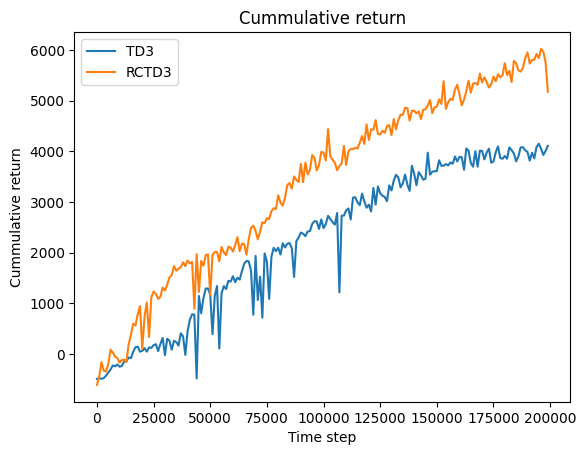

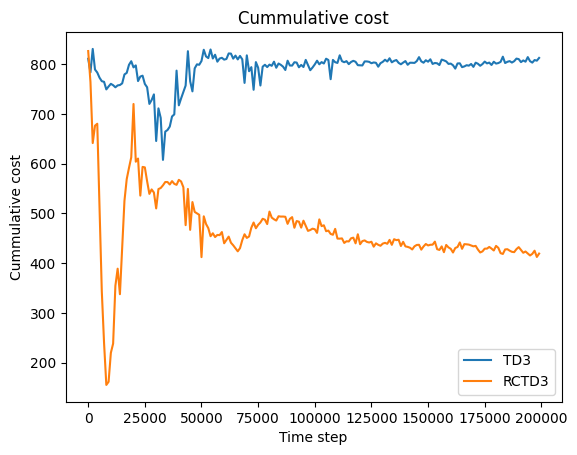

In [ ]:
#Plot the cummulative return and cummulative cost
steps = np.arange(200) * record_period
plt.plot(steps, td3_info["return"], label='TD3')
plt.plot(steps, rctd3_info["return"], label='RCTD3')
plt.xlabel('Time step')
plt.ylabel('Cummulative return')
plt.title("Cummulative return")
plt.legend()
plt.show()
# Create the second plot
plt.plot(steps, td3_info["return_cost"], label='TD3')
plt.plot(steps, rctd3_info["return_cost"], label='RCTD3')
plt.xlabel('Time step')
plt.ylabel('Cummulative cost')
plt.title("Cummulative cost")
plt.legend()
plt.show()


## Summary
In this tutorial, we showed how to implement the TD3 algorithm and its safe variant, we refer as RCTD3, in Pearl. Further, we elaborated on the RC framework, and empirically tested the performance of TD3 and RCTD3.
